# Laporan Klasifikasi Suara Kucing dan Anjing menggunakan CNN

## Import Library

In [16]:
import os
import glob
import pathlib

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

Bagian ini mengimpor berbagai library yang digunakan dalam proses pemrosesan sinyal audio dan pembuatan model klasifikasi menggunakan TensorFlow.

1. ```os, glob, pathlib``` Untuk manajemen file dan path dataset.
2. ```librosa``` → Digunakan untuk pemrosesan audio seperti ekstraksi fitur suara.
3. ```matplotlib.pyplot, seaborn``` → Untuk visualisasi data audio dalam bentuk grafik.
4. ```numpy``` → Untuk operasi numerik dan manipulasi array.
5. ```tensorflow``` → Library utama untuk membangun model deep learning.
6. ```tensorflow.keras.layers, tensorflow.keras.models``` → Modul untuk membuat arsitektur model menggunakan Keras.
7. ```IPython.display``` → Untuk menampilkan output interaktif di Jupyter Notebook.

In [17]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Bagian ini digunakan untuk memastikan hasil eksperimen konsisten setiap kali kode dijalankan.

1. ```seed = 42``` → Menetapkan nilai seed agar angka acak tetap sama setiap kali program dijalankan.
2. ```tf.random.set_seed(seed)``` → Mengatur seed untuk operasi yang menggunakan TensorFlow.
3. ```np.random.seed(seed)``` → Mengatur seed untuk operasi yang menggunakan NumPy.

## Transoformasi Sinyal ke Spektogram

Sinyal audio berbentuk gelombang 1D dalam domain waktu. Untuk menganalisis dan mengklasifikasikan sinyal tersebut menggunakan model berbasis CNN, kita perlu mengubahnya ke dalam representasi spektrogram, yang merupakan bentuk 2D dalam domain waktu-frekuensi. Spektrogram diperoleh dengan menerapkan Short-Time Fourier Transform (STFT) pada sinyal audio.

### Parameter Konfigurasi

In [18]:
FRAME_LENGTH = 255
FRAME_STEP = 128

1. ```FRAME_LENGTH = 255``` → Menentukan panjang tiap frame dalam STFT.
2. ```FRAME_STEP = 128``` → Menentukan jarak antara frame yang berdekatan.

*Tujuan:*
Dengan membagi sinyal menjadi potongan-potongan kecil (frame), STFT memungkinkan kita melihat bagaimana frekuensi berubah seiring waktu.

In [19]:
class Spectrogram():

  def __init__(self):
    pass

  def get_spectrogram(self, waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

  def plot_spectrogram(self, spectrogram, ax):
    if (len(spectrogram.shape) > 2):
      assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)

    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    

1. Fungsi ```get_spectrogram``` : Fungsi ini mengubah sinyal audio 1D menjadi spektrogram 2D yang bisa digunakan dalam model CNN.
    *Penjelasan Langkah-langkahnya* :

    1. ```tf.signal.stft(waveform, frame_length, frame_step)```
        - Menerapkan Short-Time Fourier Transform (STFT) pada sinyal waveform untuk mendapatkan representasi dalam domain frekuensi.
        - Menghasilkan nilai kompleks (magnitude dan fase).
    2. ```tf.abs(spectrogram)```
        - Mengambil nilai absolut untuk mendapatkan magnitude tanpa fase.
    3. ```spectrogram[..., tf.newaxis]```
        - Menambahkan dimensi channel sehingga formatnya menjadi (time, frequency, 1), agar dapat diproses seperti citra oleh CNN.

2. Fungsi ```plot_spectrogram``` : Fungsi ini digunakan untuk menampilkan spektrogram dalam bentuk visual.
 Penjelasan Langkah-langkahnya:
 
    1. ```np.squeeze(spectrogram, axis=-1)```
        -   Jika spektrogram memiliki dimensi ekstra, hapus dimensi channel agar menjadi 2D.
    2.  ```np.log(spectrogram.T + np.finfo(float).eps)```
        -   Menerapkan logarithmic scaling agar perbedaan intensitas lebih jelas.
        -   np.finfo(float).eps``` adalah nilai epsilon untuk menghindari kesalahan log(0).
    3. ```ax.pcolormesh(X, Y, log_spec)```
        - Menggunakan pseudocolor plot untuk menampilkan spektrum sebagai heatmap.
        - Sumbu X = waktu, Y = frekuensi.

## DataLoader untuk Klasifikasi Suara Anjing & Kucing

Kode ini bertanggung jawab untuk memuat, memproses, dan membagi dataset audio menjadi training, validation, dan test dataset agar dapat digunakan dalam model deep learning berbasis CNN 1D.

### 1. Parameter Konfigurasi

In [20]:
BATCH_SIZE = 32
OUTPUT_SEQUENCE_LENGTH = 16000
TRAIN_DATASET = 'cats_dogs/train'
VALIDATION_DATASET = 'cats_dogs/test'

- ```BATCH_SIZE = 32``` → Jumlah sampel yang diproses dalam satu iterasi pelatihan.
- ```OUTPUT_SEQUENCE_LENGTH = 16000``` → Panjang output sinyal setelah preprocessing.
    - 16000 sample mewakili 1 detik audio dengan sample rate 16 kHz.
    
- ```TRAIN_DATASET = 'cats_dogs/train'``` → Lokasi folder dataset untuk training.
- ```VALIDATION_DATASET = 'cats_dogs/test'``` → Lokasi folder dataset untuk validasi & testing.

### 2. CLass ```AudioDataLoader```

- Memuat dataset audio dari direktori menggunakan ```tf.keras.utils.audio_dataset_from_directory()```.
- Mengembalikan dataset dalam bentuk yang siap untuk pelatihan.
- Membagi dataset validasi menjadi validation set dan test set.

In [21]:
class AudioDataLoader():

  def __init__(self):
    pass


  def get_training_dataset_and_class_names(self):
    train_ds = tf.keras.utils.audio_dataset_from_directory(
      TRAIN_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    class_names = train_ds.class_names
    train_ds = train_ds.map(self._squeeze, tf.data.AUTOTUNE)
    return train_ds, class_names

 
  def get_validation_and_test_datasets(self):
    validation_ds = tf.keras.utils.audio_dataset_from_directory(
      VALIDATION_DATASET,
      batch_size=BATCH_SIZE,
      output_sequence_length=OUTPUT_SEQUENCE_LENGTH,
      seed=seed
    )

    validation_ds = validation_ds.map(self._squeeze, tf.data.AUTOTUNE)
    validation_ds, test_ds = self._get_test_dataset(validation_ds)

    return validation_ds, test_ds

 
  def _get_test_dataset(self, validation_dataset):
    validation_dataset = validation_dataset.shard(num_shards=2, index=0)
    test_dataset = validation_dataset.shard(num_shards=2, index=1)
    return validation_dataset, test_dataset

  def _squeeze(self, waveforms, labels):
    waveforms = tf.squeeze(waveforms, axis=-1)
    return waveforms, labels

In [44]:
import os

# Path ke dataset
TRAIN_DATASET = 'cats_dogs/train'
TEST_DATASET = 'cats_dogs/test'

def count_files_in_dataset(dataset_path):
    class_counts = {}
    total_count = 0

    for class_name in os.listdir(dataset_path):
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count
            total_count += count

    return class_counts, total_count

# Hitung jumlah data di setiap dataset
train_counts, train_total = count_files_in_dataset(TRAIN_DATASET)
test_counts, test_total = count_files_in_dataset(TEST_DATASET)

# Tampilkan hasil
print("Jumlah data dalam TRAIN_DATASET:")
for class_name, count in train_counts.items():
    print(f"  {class_name}: {count} sampel")
print(f"Total: {train_total} sampel\n")

print("Jumlah data dalam TEST_DATASET:")
for class_name, count in test_counts.items():
    print(f"  {class_name}: {count} sampel")
print(f"Total: {test_total} sampel")


Jumlah data dalam TRAIN_DATASET:
  cat: 125 sampel
  dog: 85 sampel
Total: 210 sampel

Jumlah data dalam TEST_DATASET:
  cats: 39 sampel
  test: 28 sampel
Total: 67 sampel


### 3. Fungsi ```get_training_dataset_and_class_names()```
Memuat dataset pelatihan dari folder cats_dogs/train dan mengembalikan:

1. Dataset training dalam format TensorFlow Dataset.
2. Nama kelas yang tersedia dalam dataset (misalnya ["Anjing", "Kucing"]).

Penjelasan Langkah-langkahnya:

- Memuat dataset audio dengan ```audio_dataset_from_directory()```, memastikan setiap file audio memiliki panjang tetap 16.000 sample.
- Mendapatkan daftar kelas dari dataset (misalnya ```["Anjing", "Kucing"]```).
- Melakukan preprocessing dengan ```_squeeze()``` untuk menghilangkan dimensi ekstra dalam waveform.

### 4. Fungsi ```get_validation_and_test_datasets()```
Memuat dataset validasi dari folder cats_dogs/test dan membaginya menjadi validation set dan test set.
Penjelasan:

- Memuat dataset validasi dari folder ```cats_dogs/test```.
- Melakukan preprocessing dengan ```_squeeze()```untuk menghilangkan dimensi tambahan.
- Memanggil ```_get_test_dataset()``` untuk membagi dataset validasi menjadi validation set (50%) dan test set (50%).

### 5. Fungsi ```_get_test_dataset()```
Membagi dataset validasi menjadi 50% validation set dan 50% test set.

Penjelasan:
- ```validation_dataset.shard(num_shards=2, index=0)``` → Mengambil setengah dataset sebagai validation set.
- ```validation_dataset.shard(num_shards=2, index=1)``` → Mengambil setengah lainnya sebagai test set.

*Mengapa ini dilakukan ?* Untuk memastikan model dapat diuji pada data yang belum pernah dilihat sebelumnya.

### 5. Fungsi ```_squeeze()```
Fungsi ini menghapus dimensi ekstra dari data waveform.
Penjelasan:

```tf.squeeze(waveforms, axis=-1)``` menghapus dimensi tambahan sehingga format data menjadi ```(batch_size, sequence_length)```.

## Menampilkan Dataset Audio

In [22]:
dataloader = AudioDataLoader()
train_ds, class_names = dataloader.get_training_dataset_and_class_names()
validation_ds, test_ds = dataloader.get_validation_and_test_datasets()

Found 210 files belonging to 2 classes.
Found 67 files belonging to 2 classes.


## Validasi Dataset Audio

Guna melihat bentuk ```(shape)``` dari data audio ```(waveforms)``` dan label ```(labels)``` dalam satu batch dari dataset pelatihan ```(train_ds)``` dan Melihat Class dari 2 Data Tersebut.

In [23]:
print(class_names)
for waveforms, labels in train_ds.take(1):
  print(waveforms.shape)
  print(labels.shape)

['cat', 'dog']
(32, 16000)
(32,)


Penjelasan output:

1. ```(32, 16000)``` → Ada 32 audio sample dalam satu batch, masing-masing memiliki 16.000 sample data suara (1 detik audio).
2. ```(32,)``` → Ada 32 label, masing-masing terkait dengan satu file audio dalam batch.

### Memvisualisasikan bentuk gelombang audio dari dataset pelatihan ``(train_ds)``.

1. ``plt.figure(figsize=(16,9))``
    - Membuat figure dengan ukuran 16x9 inci untuk menampilkan grafik lebih besar.

2.  ``plt.subplots_adjust(bottom=-0.2)``
    - Mengatur tata letak subplot agar tidak terpotong di bagian bawah.

3.  ``for i in range(9):``
    - Melakukan iterasi untuk menampilkan 9 sampel audio pertama dari waveforms.

4.  ``plt.subplot(3, 3, i+1)``
    - Membuat layout 3x3 (3 baris, 3 kolom) untuk menampilkan 9 gelombang audio.

4. ``plt.plot(waveforms[i].numpy())``
    - Menggambar bentuk gelombang audio ke dalam grafik.

5.  ``plt.title(class_names[labels[i]])``
    - Menampilkan nama kelas di atas setiap grafik (misalnya "Anjing" atau "Kucing").

6.  ``plt.axis([0, 16000, -1, 1])``
    - ``Sumbu X (0 → 16000)`` : Menunjukkan waktu dalam sample (karena audionya berdurasi 1 detik @16kHz).
    - ``Sumbu Y (-1 → 1)`` : Rentang amplitudo sinyal audio yang dinormalisasi.

7.  ``plt.show()``
    - Menampilkan semua plot dalam satu figure.

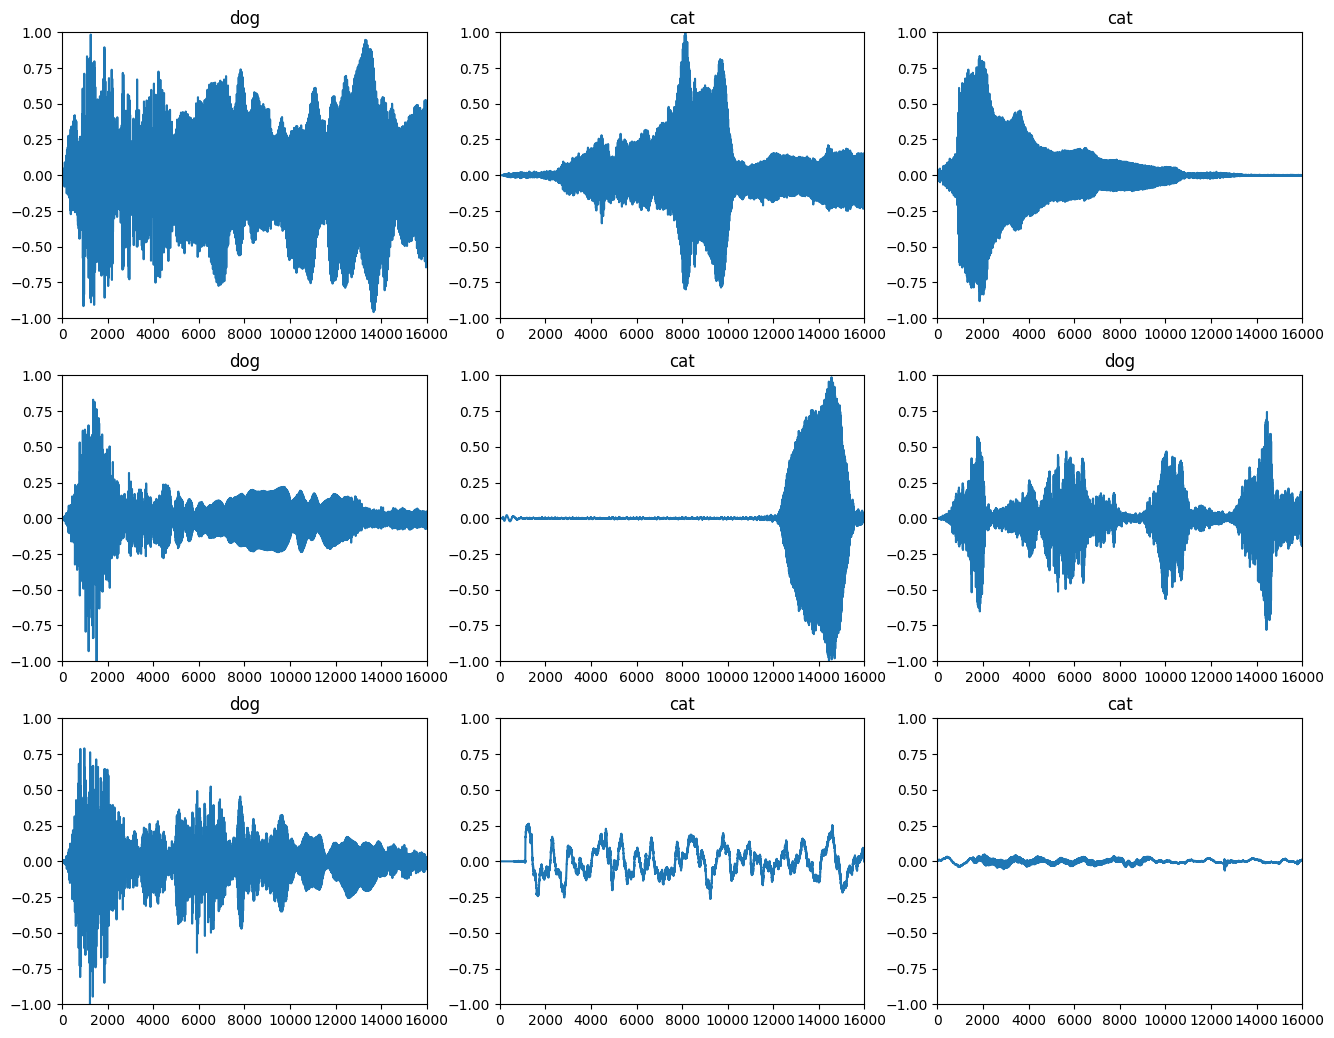

In [24]:
plt.figure(figsize=(16,9))
plt.subplots_adjust(bottom=-0.2)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.plot(waveforms[i].numpy())
  plt.title(class_names[labels[i]])
  plt.axis([0, 16000, -1, 1])

## Menghasilkan Spektogram dari Wavefrom

In [25]:
spec = Spectrogram()
for j in range(6):
  label = class_names[labels[j]]
  waveform = waveforms[j]
  spectrogram = spec.get_spectrogram(waveform)
  print(f"\nLabel: {label}")
  print(f"Spectrogram Shape: {spectrogram.shape}\n")

  display.display(display.Audio(waveform, rate=16000))


Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)




Label: cat
Spectrogram Shape: (124, 129, 1)




Label: dog
Spectrogram Shape: (124, 129, 1)



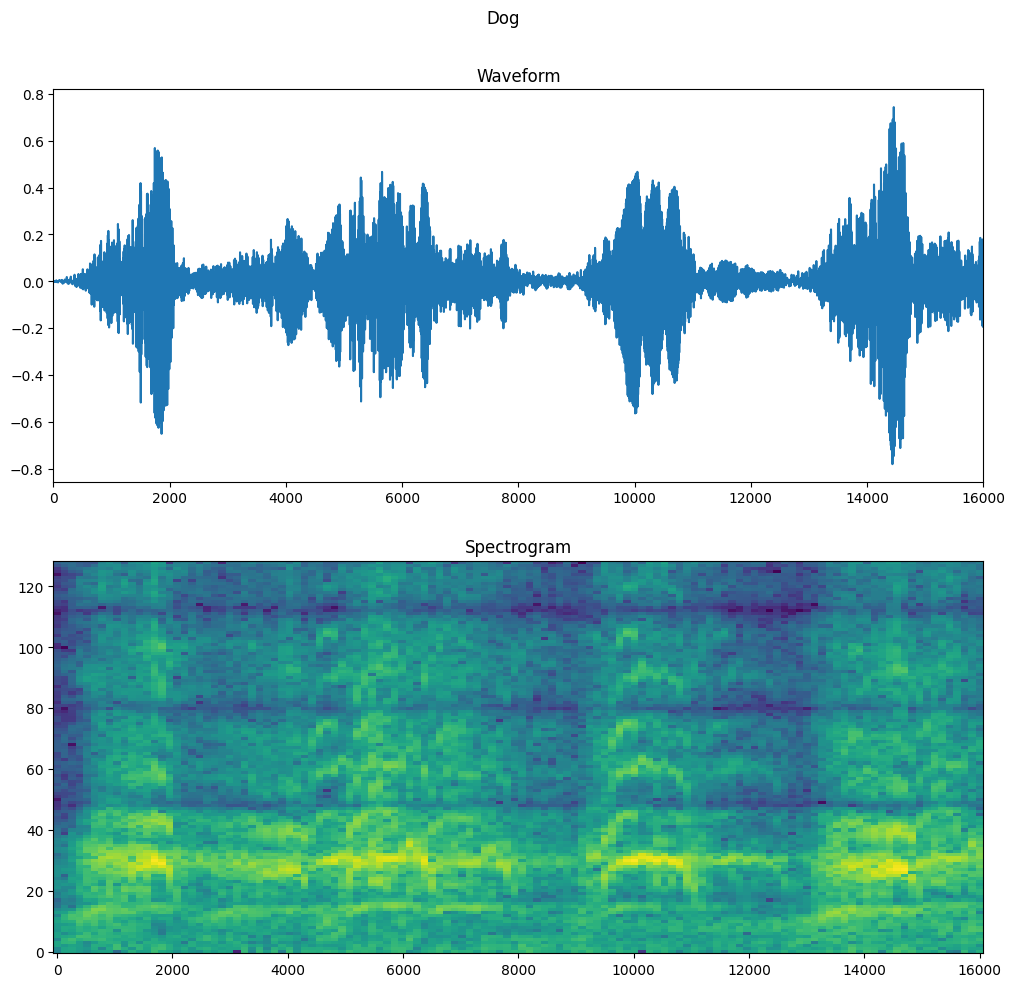

In [26]:
fig, axes = plt.subplots(2, figsize=(12, 8))
plt.subplots_adjust(bottom=-0.2)

timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

spec.plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

## Membuat Spectogram Dataset Agar Bisa digunakan Di CNN

Kode ini mengubah dataset audio mentah menjadi dataset spektrogram sebelum digunakan dalam pelatihan model CNN 1D. Proses ini dilakukan dengan memetakan setiap data audio ke dalam bentuk spektrogram menggunakan fungsi ``get_spectrogram()``, sehingga model dapat mengenali pola dalam suara dengan lebih efektif. Dataset yang telah dikonversi tetap mempertahankan label asli, memastikan bahwa informasi kategori suara tidak hilang. Konversi ini diterapkan pada dataset pelatihan ``(train_spectrogram_ds)``, validasi ``(validation_spectrogram_ds)``, dan pengujian ``(test_spectrogram_ds)`` agar seluruh proses pelatihan dan evaluasi menggunakan data dalam bentuk yang sesuai untuk model CNN.

In [27]:
train_spectrogram_ds = train_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

validation_spectrogram_ds = validation_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

test_spectrogram_ds = test_ds.map(
    map_func=lambda audio, label: (spec.get_spectrogram(audio), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

In [28]:
for example_spectrograms, example_labels in train_spectrogram_ds.take(1):
  break

### Plot beberapa spektogram untuk memverifikasi bahwa spektogram tersebut terlihat benar

Kode ini digunakan untuk memvisualisasikan spektrogram dari sampel audio dalam dataset. Dengan menggunakan **matplotlib**, kode ini membuat grid subplot berukuran 3x3 untuk menampilkan total **9** spektrogram dari **example_spectrograms**. Setiap subplot diisi dengan hasil transformasi audio ke spektrogram menggunakan metode `plot_spectrogram()`, dan diberi judul sesuai dengan label kelas suara yang bersangkutan. Ini membantu dalam memahami bagaimana data suara yang telah dikonversi ke bentuk spektrogram terlihat sebelum digunakan dalam model pembelajaran mesin.

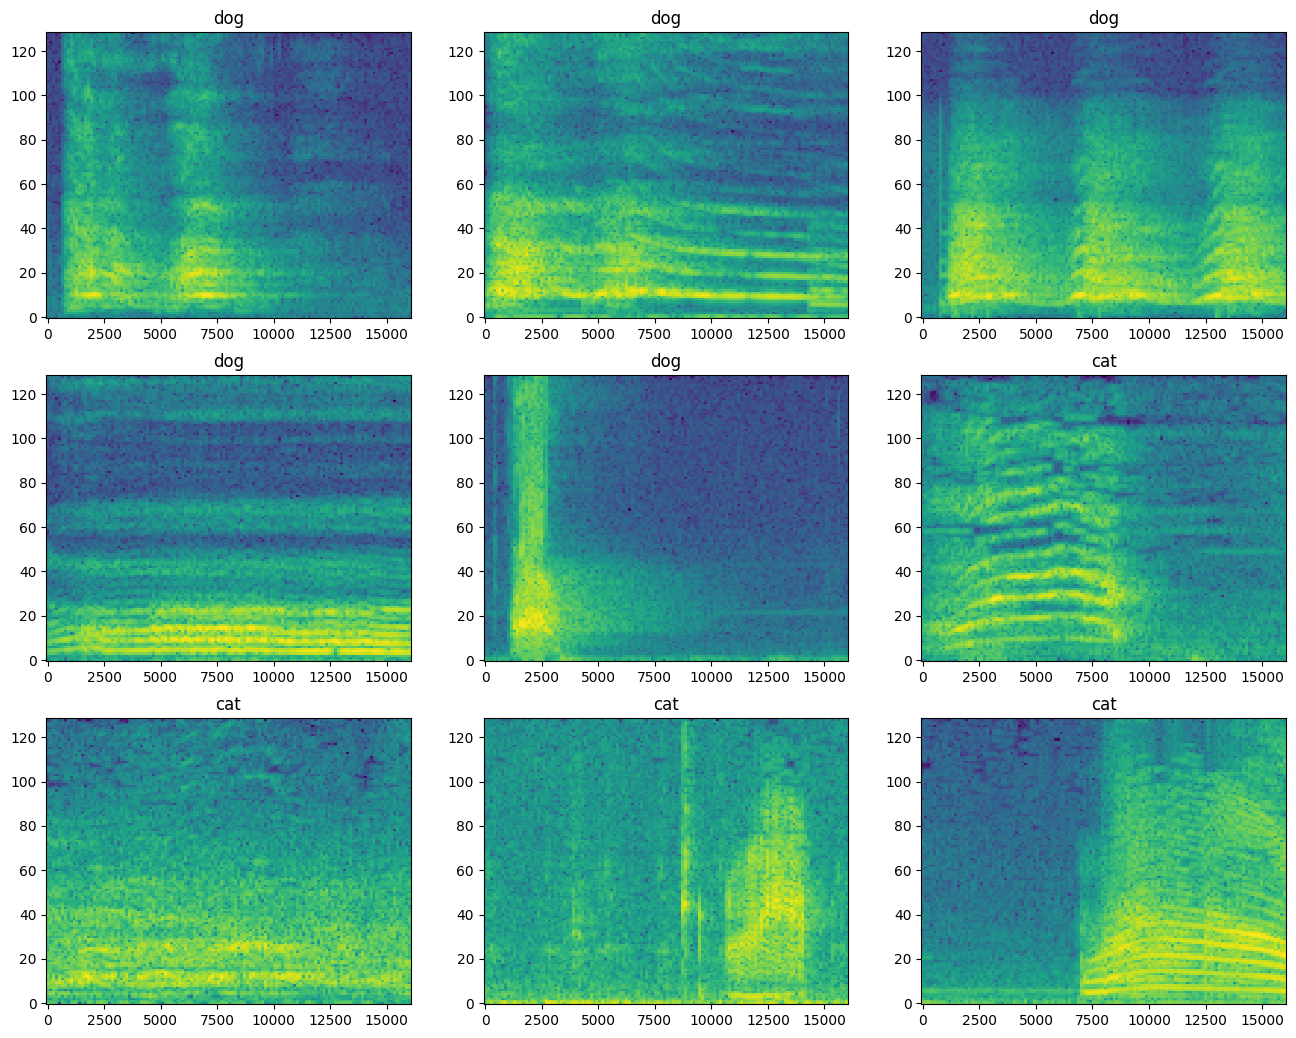

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
plt.subplots_adjust(bottom=-0.2)

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spec.plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(class_names[example_labels[i].numpy()])

plt.show()

### Meningkatkan efisiensi dalam pemrosesan dataset dengan menerapkan caching dan prefetching pada TensorFlow

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_spectrogram_ds = validation_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Kode ini digunakan untuk meningkatkan efisiensi dalam pemrosesan dataset dengan menerapkan **caching** dan **prefetching** pada TensorFlow `tf.data.Dataset`.  

1. **`cache()`**: Menyimpan dataset dalam memori setelah pertama kali di-load, sehingga mempercepat proses pelatihan dengan menghindari pembacaan ulang dari disk.  
2. **`prefetch(tf.data.AUTOTUNE)`**: Memungkinkan TensorFlow untuk memuat batch data berikutnya di latar belakang saat model sedang memproses batch saat ini, sehingga meningkatkan efisiensi training dengan **parallel processing**.  

Dengan kombinasi ini, dataset `train_spectrogram_ds`, `validation_spectrogram_ds`, dan `test_spectrogram_ds` dapat diproses lebih cepat selama pelatihan model, mengurangi waktu tunggu dalam pipeline data.

## Membuat CNN Model

In [31]:
input_shape = example_spectrograms.shape[1:]
print(input_shape)

num_labels = len(class_names)

normalization = tf.keras.layers.Normalization()

normalization.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),
    tf.keras.layers.Resizing(32, 32),
    normalization,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_labels)
])

model.summary()
model.save('audio_classification_model.h5') 

(124, 129, 1)


c:\Users\DELL\anaconda3\envs\PengenalanPola\lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,357 (9.36 MB)

 Trainable params: 2,452,354 (9.35 MB)

 Non-trainable params: 3 (16.00 B)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Melatih Model CNN

Kode ini digunakan untuk melatih model CNN menggunakan dataset spektrogram suara dengan metode backpropagation selama 10 epoch. Dataset pelatihan (`train_spectrogram_ds`) digunakan untuk melatih model, sementara dataset validasi (`validation_spectrogram_ds`) membantu mengevaluasi performa model di setiap epoch. Dengan setiap iterasi, model menyesuaikan bobotnya untuk meningkatkan akurasi prediksi suara. Hasil pelatihan disimpan dalam variabel `history`, yang nantinya dapat digunakan untuk menganalisis tren akurasi dan loss selama proses pelatihan. Model ini bertujuan untuk mengklasifikasikan suara dengan lebih akurat seiring bertambahnya jumlah epoch.

In [33]:
EPOCHS = 10

history = model.fit(
    train_spectrogram_ds,
    validation_data=validation_spectrogram_ds,
    epochs=EPOCHS
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.7212 - loss: 0.5909 - val_accuracy: 0.8857 - val_loss: 0.3161
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8864 - loss: 0.3919 - val_accuracy: 0.8286 - val_loss: 0.3375
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9140 - loss: 0.2809 - val_accuracy: 0.9143 - val_loss: 0.3136
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9297 - loss: 0.2116 - val_accuracy: 0.8857 - val_loss: 0.3876
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9161 - loss: 0.2047 - val_accuracy: 0.8857 - val_loss: 0.4269
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9222 - loss: 0.1786 - val_accuracy: 0.9143 - val_loss: 0.4400
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9554 - loss: 0.1300 - val_accuracy: 0.8857 - val_loss: 0.4877
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9527 - loss: 0.1458 - val_accuracy: 0.8571 - val_loss: 0.5533

### Klasifikasi Report

Text(0.5, 0, 'Epoch')

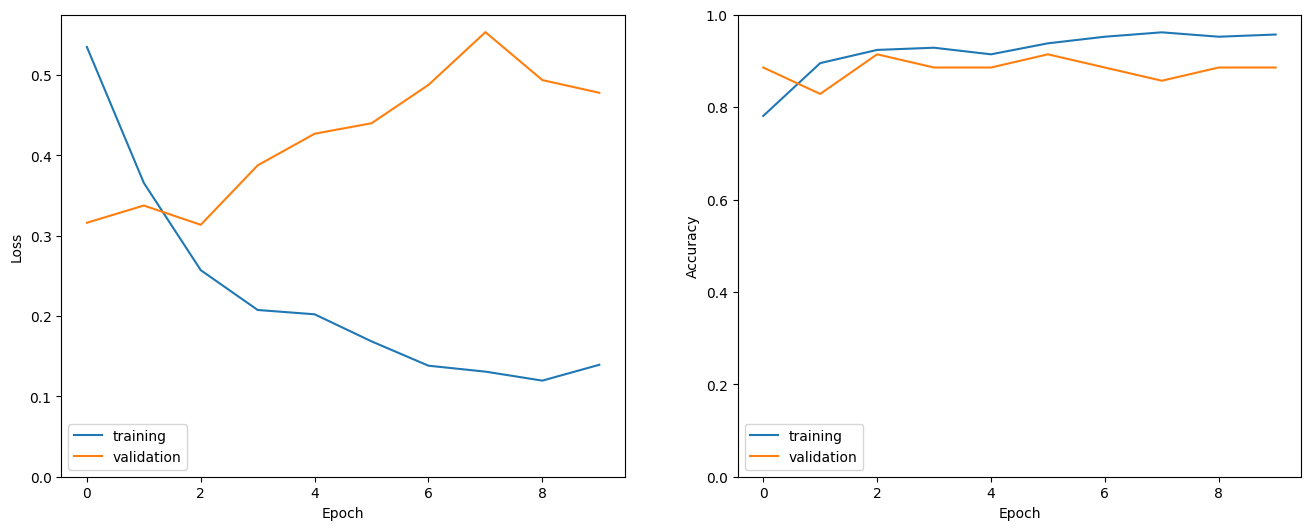

In [34]:
metrics = history.history
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['training', 'validation'])
plt.ylim([0, max(plt.ylim())])
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['training', 'validation'])
plt.ylim([0, 1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [41]:
train_count = sum(1 for _ in train_spectrogram_ds)
val_count = sum(1 for _ in validation_spectrogram_ds)
test_count = sum(1 for _ in test_spectrogram_ds)


print(f"Jumlah data training: {train_count}")
print(f"Jumlah data validasi: {val_count}")
print(f"Jumlah data testing: {test_count}")


Jumlah data training: 7
Jumlah data validasi: 2
Jumlah data testing: 1


In [35]:
model.evaluate(test_spectrogram_ds, return_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6667 - loss: 0.4107


{'accuracy': 0.6666666865348816, 'loss': 0.41068729758262634}

In [36]:
y_pred = model.predict(test_spectrogram_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


In [37]:
y_pred = tf.argmax(y_pred, axis=1)

In [38]:
y_true = tf.concat([y for x, y in test_spectrogram_ds], axis=0)

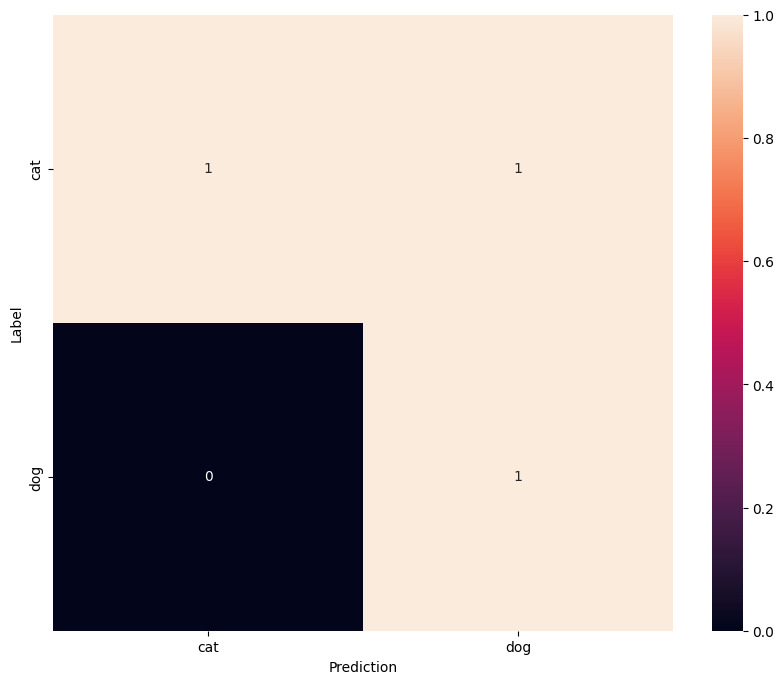

In [39]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=class_names,
            yticklabels=class_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Uji Model Klasifikasi

Kode ini digunakan untuk menguji model klasifikasi suara dengan sampel audio tertentu. File audio dipilih dari dataset (`cats_dogs/dog_barking_113.wav`), dibaca sebagai gelombang suara menggunakan `tf.audio.decode_wav`, lalu dikonversi menjadi spektrogram dengan fungsi `get_spectrogram()`. Spektrogram ini kemudian digunakan sebagai input untuk model yang telah dilatih. Hasil prediksi ditampilkan dalam bentuk grafik batang dengan nilai probabilitas untuk masing-masing kelas (`cat` dan `dog`). Selain itu, gelombang suara asli juga ditampilkan dengan `display.Audio()`, memungkinkan pengguna untuk mendengarkan suara yang diuji.

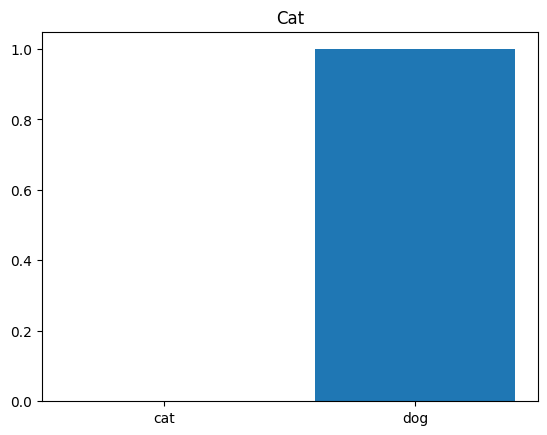

In [40]:
# x = 'cats_dogs/cat_168.wav'
x = 'cats_dogs/dog_barking_113.wav'
# x = '/anjing.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = spec.get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['cat', 'dog']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('Cat')
plt.show()

display.display(display.Audio(waveform, rate=16000))